# Facial Emotion Recognition Project

In this project, I aim to recognize facial emotions using a **non-AI approach**. Instead of relying on pre-trained deep learning models, I focus on extracting key facial landmarks from a person's face and use these points to classify emotions. The system calculates various facial feature movements and distances, such as the openness of the mouth, the width of the smile, and the positioning of the eyes and eyebrows.

The key idea behind this approach is to develop a heuristic system that doesn't require AI or machine learning. By analyzing the relative positions of these facial points, the system is designed to classify emotions such as **Sad**, **Happy**, **Angry**, **Surprised**, **Scared**, and **Neutral**.

### Comparison with AI-based Emotion Recognition

To evaluate the performance of this non-AI approach, I compare the results with those obtained from an **AI-based emotion recognizer**. For this, I use **DeepFace**, a pre-trained deep learning model, to classify emotions from the same videos. This comparison helps me understand the strengths and limitations of both approaches and how well the non-AI method performs in comparison to state-of-the-art AI models.

## Video Capture

### Reading Video Frames

The `read_video` function is responsible for opening a video file and extracting its frames one by one using the OpenCV library. This is a crucial step in the emotion recognition pipeline, as it allows us to process each frame individually to detect and classify facial expressions. By using a generator (`yield`), the function efficiently handles large videos without loading all frames into memory at once. This makes it well-suited for real-time video processing tasks.

In [ ]:
import cv2
import os

# Function to read a video file (for real-time) frame by frame using OpenCV
def read_video(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        yield frame

    cap.release()

### Recording a Video from Webcam

The `record_video` function allows the user to record a video using their computer's webcam. By default, it records for 10 seconds at 20 frames per second and saves the video. The function uses OpenCV to access the webcam (`VideoCapture(0)`), define the output video format, and write each frame to the output file.

During the recording, a live window shows the captured frames and allows the user to stop early by pressing the **'q'** key.

In [2]:
# Function to record a video from the webcam and save it to a file
def record_video(output_path="data/recorded_video.avi", duration=10, fps=20):
    cap = cv2.VideoCapture(0)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID') # XVID codec for AVI format
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    frame_count = 0
    max_frames = duration * fps

    print("[INFO] Recording started. Look at the camera...")
    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)
        cv2.imshow("Recording... Press 'q' to stop early", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        frame_count += 1

    cap.release()
    out.release()
    try:
        while cv2.getWindowProperty("Recording... Press 'q' to stop early", cv2.WND_PROP_VISIBLE) >= 1:
            cv2.destroyWindow("Recording... Press 'q' to stop early")
            cv2.waitKey(1)
    except:
        pass

    print(f"[INFO] Recording completed. Video saved to {output_path}")

## Emotion Detection

### Face Detection Using Haar Cascades

The `detect_faces` function takes a single video frame as input and uses a pre-trained Haar cascade classifier to detect faces. The image is first converted to grayscale, as the face detection algorithm works on intensity values rather than color. To enhance the image contrast, histogram equalization is applied to the grayscale image using `cv2.equalizeHist()`, which stretches the intensity range and makes it easier to detect faces, especially in poorly lit conditions.

Then, the detectMultiScale method scans the image at multiple scales and returns a list of rectangles representing the detected faces. This helps in accurately identifying faces at different sizes or distances from the camera.

The classifier is loaded from OpenCV’s built-in `haarcascade_frontalface_default.xml`, which is commonly used for detecting front-facing human faces.

In [3]:
import cv2

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Function to detect faces in a given video frame using Haar cascades
def detect_faces(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    return faces

### Facial Landmark Extraction

The `extract_landmarks` function uses MediaPipe's Face Mesh model to detect and extract 3D facial landmarks from a video frame. It first converts the image from BGR to RGB (as required by MediaPipe), then processes it to identify facial features such as eyes, mouth, and contours.
If a face is detected, it draws a tesselated mesh over the face using MediaPipe's drawing utilities.

In [4]:
import mediapipe as mp

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False,
                                  max_num_faces=1,
                                  refine_landmarks=True,
                                  min_detection_confidence=0.5,
                                  min_tracking_confidence=0.5)

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Function to extract facial landmarks using MediaPipe
def extract_landmarks(frame, return_label=False):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)
    emotion_label = None

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=frame,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())

            emotion_label = classify_emotion(face_landmarks)

    if return_label:
        return frame, emotion_label
    return frame

I0000 00:00:1744705900.218577 1449183 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3


In [5]:
def classify_emotion_3(landmarks):
    """
    Rule-based emotion classification using Mediapipe face landmarks.
    Normalizes all distances by face width to improve robustness.
    """
    idx_top_lip = 13
    idx_bottom_lip = 14
    idx_left_eye_top = 159
    idx_left_eye_bottom = 145
    idx_right_eye_top = 386
    idx_right_eye_bottom = 374
    idx_left_mouth = 61
    idx_right_mouth = 291
    idx_left_cheek = 234
    idx_right_cheek = 454
    idx_left_brow = 105
    idx_left_eye = 33
    idx_right_brow = 334
    idx_right_eye = 263

    def distance(pt1, pt2):
        return ((pt1.x - pt2.x)**2 + (pt1.y - pt2.y)**2) ** 0.5

    try:
        face_width = distance(landmarks.landmark[idx_left_cheek], landmarks.landmark[idx_right_cheek])
        if face_width == 0:
            return "Unknown"

        mouth_open = distance(landmarks.landmark[idx_top_lip], landmarks.landmark[idx_bottom_lip]) / face_width
        smile_width = distance(landmarks.landmark[idx_left_mouth], landmarks.landmark[idx_right_mouth]) / face_width
        eye_open_left = distance(landmarks.landmark[idx_left_eye_top], landmarks.landmark[idx_left_eye_bottom]) / face_width
        eye_open_right = distance(landmarks.landmark[idx_right_eye_top], landmarks.landmark[idx_right_eye_bottom]) / face_width
        brow_to_eye_left = distance(landmarks.landmark[idx_left_brow], landmarks.landmark[idx_left_eye]) / face_width
        brow_to_eye_right = distance(landmarks.landmark[idx_right_brow], landmarks.landmark[idx_right_eye]) / face_width

        avg_eye_open = (eye_open_left + eye_open_right) / 2
        avg_brow_drop = (brow_to_eye_left + brow_to_eye_right) / 2

        #print(f"mouth_open={mouth_open:.3f}, smile_width={smile_width:.3f}, eye_open={avg_eye_open:.3f}, brow_drop={avg_brow_drop:.3f}")

        if mouth_open > 0.15 and avg_eye_open > 0.1:
            return "Surprised"
        elif smile_width > 0.45 and mouth_open > 0.04:
            return "Happy"
        elif avg_eye_open < 0.07 and mouth_open < 0.04 and avg_brow_drop < 0.4:
            return "Sad"
        else:
            return "Neutral"
    except:
        return "Unknown"

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


W0000 00:00:1744705900.235517 1449478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744705900.241905 1449481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


### **Emotion Classification Based on Facial Landmarks**

The `classify_emotion` function analyzes the distances of key facial landmarks to predict emotions such as "Sad", "Angry", "Happy", "Surprised", "Scared", or "Neutral". It calculates various facial features' relative sizes and positions, including the mouth's openness, smile width, eye openness, eyebrow movement, and the curvature of the mouth.

This classifier **does not use AI**; instead, it relies on **handcrafted thresholds** for specific facial feature movements. These thresholds were chosen based on heuristics, not machine learning.

#### **Function Workflow**:
- It computes the following metrics:
  - **Mouth openness**: The distance between the top and bottom lips.
  - **Smile width**: The distance between the left and right corners of the mouth.
  - **Eye openness**: The distance between the top and bottom eyelids for both eyes.
  - **Eyebrow movement**: The vertical distance between the inner and outer eyebrow landmarks.
  - **Mouth curvature**: The vertical distance between the corners of the mouth and the top lip.
  
Using these metrics, the function applies predefined thresholds to classify the emotion.

#### **Image of Facial Landmarks**:
Here is the facial landmarks used in this function for emotion classification:

<img src="mesh_map.jpg" width="1000" length="auto"/>

In [7]:
# Function to classify emotion based on facial landmarks' distances
def classify_emotion(landmarks):
    idx_top_lip = 13
    idx_bottom_lip = 14
    idx_left_eye_top = 159
    idx_left_eye_bottom = 145
    idx_right_eye_top = 386
    idx_right_eye_bottom = 374
    idx_left_mouth = 61
    idx_right_mouth = 291
    idx_upper_lip_center = 0
    idx_left_cheek = 234
    idx_right_cheek = 454
    idx_left_brow_inner = 55
    idx_left_brow_outer = 46
    idx_right_brow_inner = 285
    idx_right_brow_outer = 276

    def distance(pt1, pt2):
        return ((pt1.x - pt2.x)**2 + (pt1.y - pt2.y)**2) ** 0.5

    try:
        face_width = distance(landmarks.landmark[idx_left_cheek], landmarks.landmark[idx_right_cheek])
        if face_width == 0:
            return "Unknown"

        mouth_open = distance(landmarks.landmark[idx_top_lip], landmarks.landmark[idx_bottom_lip]) / face_width
        smile_width = distance(landmarks.landmark[idx_left_mouth], landmarks.landmark[idx_right_mouth]) / face_width
        eye_open_left = distance(landmarks.landmark[idx_left_eye_top], landmarks.landmark[idx_left_eye_bottom]) / face_width
        eye_open_right = distance(landmarks.landmark[idx_right_eye_top], landmarks.landmark[idx_right_eye_bottom]) / face_width
        avg_eye_open = (eye_open_left + eye_open_right) / 2
        left_brow_diagonal = landmarks.landmark[idx_left_brow_inner].y - landmarks.landmark[idx_left_brow_outer].y
        right_brow_diagonal = landmarks.landmark[idx_right_brow_inner].y - landmarks.landmark[idx_right_brow_outer].y
        mouth_curve_left = landmarks.landmark[idx_left_mouth].y - landmarks.landmark[idx_top_lip].y
        mouth_curve_right = landmarks.landmark[idx_right_mouth].y - landmarks.landmark[idx_top_lip].y

        #print(f"mouth_open={mouth_open:.3f}, smile_width={smile_width:.3f}, eye_open={avg_eye_open:.3f}, left_brow_diag={left_brow_diagonal:.3f}, right_brow_diag={right_brow_diagonal:.3f}, mouth_curve=({mouth_curve_left:.3f}, {mouth_curve_right:.3f})")

        if (mouth_curve_left >= 0.016 or mouth_curve_right >= 0.016) and mouth_open < 0.008 and avg_eye_open < 0.12:
            return "Sad"
        elif mouth_open < 0.03 and avg_eye_open < 0.11 and (left_brow_diagonal > 0.007 or right_brow_diagonal > 0.007):
            return "Angry"
        elif mouth_open > 0.3 and avg_eye_open > 0.10 and smile_width < 0.475:
            return "Surprised"
        elif 0.1 < mouth_open < 0.3 and avg_eye_open < 0.14 and smile_width < 0.45:
            return "Scared"
        elif smile_width >= 0.45 and mouth_open > 0.02 and mouth_open < 0.3:
            return "Happy"
        else:
            return "Neutral"
    except:
        return "Unknown"

## Main Function for Emotion Detection

The `emotion_detection` function works as a main and orchestrates the emotion detection process by providing two modes: processing a recorded video or running in real-time camera mode. 

- **Recorded Video Mode**: If `real_time` is set to `False`, the function either records a new video or processes an existing one. The video is processed frame by frame, where faces are detected, facial landmarks are extracted, and the emotion is classified. Detected faces are highlighted with rectangles, and the emotion label is displayed on the frame. The processed frames are then saved into a new video file.

- **Real-Time Mode**: If `real_time` is set to `True`, the webcam feed is processed live. Each frame is analyzed for faces, landmarks, and emotions, with the emotion displayed on the frame.

The function handles both scenarios, making it flexible for real-time emotion detection or processing pre-recorded videos, which is useful for applications such as video analysis or interactive emotion recognition systems.

In [8]:
def emotion_detection(use_recorded_video=True, real_time=False, video_path='data/recorded_video.avi'):
    """
    Main function for emotion detection from video.
    
    Args:
        use_recorded_video (bool): Whether to use a newly recorded video or existing file
        real_time (bool): Whether to run in real-time camera mode
    """
    if not real_time:
        # Process recorded video
        os.makedirs("results", exist_ok=True)
        
        if use_recorded_video:
            print("[INFO] Recording a new video...")
            record_video(output_path="data/recorded_video.avi", duration=20, fps=20)
            video_path = "data/recorded_video.avi"

        output_path = "results/output_video.mp4"
        print("[INFO] Starting video processing...")
        
        # Get video properties
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("[ERROR] Could not open video file")
            return
            
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cap.release()
        
        # Create output video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        # Process each frame
        for idx, frame in enumerate(read_video(video_path)):
            if frame is None:
                continue
                
            # Detect faces and draw rectangles
            faces = detect_faces(frame)
            for (x, y, w, h) in faces:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            # Extract landmarks and emotion
            frame, emotion_label = extract_landmarks(frame, return_label=True)
            
            # Add emotion label to frame
            if emotion_label:
                cv2.putText(frame, f"Emotion: {emotion_label}", (30, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
            
            # Write frame to output video
            out.write(frame)

        out.release()
        print(f"[INFO] Video saved to {output_path}")
    
    else:
        # Real-time camera mode
        print("[INFO] Starting real-time emotion detection. Press 'q' to exit.")
        cap = cv2.VideoCapture(0)
        
        if not cap.isOpened():
            print("[ERROR] Could not open webcam")
            return
        
        try:
            while True:
                ret, frame = cap.read()
                if not ret:
                    print("[ERROR] Failed to capture frame")
                    break
                
                # Detect faces and draw rectangles
                faces = detect_faces(frame)
                for (x, y, w, h) in faces:
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                
                # Extract landmarks and emotion
                frame, emotion_label = extract_landmarks(frame, return_label=True)
                
                # Add emotion label to frame
                if emotion_label:
                    cv2.putText(frame, f"Emotion: {emotion_label}", (30, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
                
                # Add instruction text
                cv2.putText(frame, "Press 'q' to quit", (frame.shape[1] - 150, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                
                # Display the frame
                cv2.imshow('Emotion Detection', frame)
                
                key = cv2.waitKey(1) & 0xFF
                if key == ord('q'):
                    break
                
        finally:
            while cv2.getWindowProperty("Recording... Press 'q' to stop early", cv2.WND_PROP_VISIBLE) >= 1:
                cv2.destroyWindow("Recording... Press 'q' to stop early")
                cv2.waitKey(1)

In [ ]:
#emotion_detection(use_recorded_video=False, real_time=False, video_path="data/all3.avi")

[INFO] Starting video processing...
[INFO] Video saved to results/output_video.mp4


## Emotion Detection Using DeepFace

The `extract_emotion` function uses the DeepFace library to analyze the facial region of interest (ROI) and extract the dominant emotion. The `DeepFace.analyze` method processes the face image and returns an analysis of several facial attributes, including emotion. By setting `actions=['emotion']`, the function specifically focuses on emotion recognition.

In [9]:
from deepface import DeepFace

# Function to extract dominant emotion from a given face region using DeepFace
def extract_emotion(face_roi):
    result = DeepFace.analyze(face_roi, actions=['emotion'], enforce_detection=False)
    emotion_label = result[0]['dominant_emotion']
    return emotion_label

## Main Function for Emotion Detection with AI

the `emotion_detection_ai` function works like `emotion_detection` function (above) but it uses AI to detect the emotion.

In [10]:
def emotion_detection_ai(use_recorded_video=True, real_time=False, video_path="data/recorded_video.avi"):
    """
    Main function for emotion detection from video.
    
    Args:
        use_recorded_video (bool): Whether to use a newly recorded video or existing file
        real_time (bool): Whether to run in real-time camera mode
    """
    if not real_time:
        # Process recorded video
        os.makedirs("results", exist_ok=True)
        
        if use_recorded_video:
            print("[INFO] Recording a new video...")
            record_video(output_path="data/recorded_video.avi", duration=15, fps=20)
            video_path = "data/recorded_video.avi"

        output_path = "results/output_video_ai.mp4"
        print("[INFO] Starting video processing...")
        
        # Get video properties
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("[ERROR] Could not open video file")
            return
            
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cap.release()
        
        # Create output video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        # Process each frame
        for idx, frame in enumerate(read_video(video_path)):
            if frame is None:
                continue
                
            # Detect faces and draw rectangles
            faces = detect_faces(frame)
            if len(faces) > 0:
                # Find the face with the largest area (width × height)
                largest_face = max(faces, key=lambda rect: rect[2] * rect[3])
                
                # Unpack coordinates of the largest face
                x, y, w, h = largest_face
                
                # Draw rectangle around the largest face only
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                
                # Crop the face region for the largest face only
                face_roi = frame[y:y+h, x:x+w]
                
                # Recognize emotion using the encapsulated function
                emotion_label = extract_emotion(face_roi)
    
                # Add emotion label to frame
                if emotion_label:
                    cv2.putText(frame, f"Emotion: {emotion_label}", (30, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
            
            # Write frame to output video
            out.write(frame)

        out.release()
        print(f"[INFO] Video saved to {output_path}")
    
    else:
        # Real-time camera mode
        print("[INFO] Starting real-time emotion detection. Press 'q' to exit.")
        cap = cv2.VideoCapture(0)
        
        if not cap.isOpened():
            print("[ERROR] Could not open webcam")
            return
        
        try:
            while True:
                ret, frame = cap.read()
                if not ret:
                    print("[ERROR] Failed to capture frame")
                    break
                
                # Detect faces and draw rectangles
                faces = detect_faces(frame)
                if len(faces) > 0:
                    # Find the face with the largest area (width × height)
                    largest_face = max(faces, key=lambda rect: rect[2] * rect[3])
                    
                    # Unpack coordinates of the largest face
                    x, y, w, h = largest_face
                    
                    # Draw rectangle around the largest face only
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    
                    # Crop the face region for the largest face only
                    face_roi = frame[y:y+h, x:x+w]
                    
                    # Recognize emotion using the encapsulated function
                    emotion_label = extract_emotion(face_roi)
        
                    # Add emotion label to frame
                    if emotion_label:
                        cv2.putText(frame, f"Emotion: {emotion_label}", (30, 30),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
                
                # Add instruction text
                cv2.putText(frame, "Press 'q' to quit", (frame.shape[1] - 150, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                
                # Display the frame
                cv2.imshow('Emotion Detection', frame)
                
                key = cv2.waitKey(1) & 0xFF
                if key == ord('q'):
                    break
                
        finally:
            while cv2.getWindowProperty("Recording... Press 'q' to stop early", cv2.WND_PROP_VISIBLE) >= 1:
                cv2.destroyWindow("Recording... Press 'q' to stop early")
                cv2.waitKey(1)

In [46]:
#emotion_detection_ai(use_recorded_video=False, real_time=False, video_path='data/all3.avi')

[INFO] Starting video processing...
[INFO] Video saved to results/output_video_ai.mp4


## Comparing Emotion Detection: Non-AI vs AI

The `compare_emotion_detection` function compares emotion detection results using two methods: a **non-AI approach** based on facial landmarks and a **DeepFace AI** model. The function processes each frame from a video (either from a provided file or the webcam), detecting faces and analyzing emotions.

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import os
from IPython.display import display

# Create necessary directory
os.makedirs('data', exist_ok=True)

def compare_emotion_detection(video_path=None, duration=30, exclude_neutral_unknown=False):
    """
    Compare emotions detected from two different methods (non-AI vs AI) and visualize the results
    directly in the Jupyter notebook.
    
    Args:
        video_path: Path to video file. If None, webcam will be used.
        duration: Maximum duration in seconds if using webcam
        exclude_neutral_unknown: If True, excludes Neutral from non-AI and Unknown from AI
    """
    # Initialize emotion counters for both methods
    emotion_counts = {
        'non_ai': defaultdict(int),
        'ai': defaultdict(int),
        'matches': 0,
        'mismatches': 0
    }
    
    frame_emotions = []  # Will store (frame_num, non_ai_emotion, ai_emotion)
    
    # Initialize video capture
    if video_path:
        cap = cv2.VideoCapture(video_path)
    else:
        cap = cv2.VideoCapture(0)  # Use webcam
        
    if not cap.isOpened():
        print("Error: Cannot open video source")
        return
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0:  # If fps couldn't be determined (like from webcam)
        fps = 30
    
    max_frames = int(duration * fps) if not video_path else float('inf')
    frame_count = 0
    
    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Detect faces using Haar cascade
        faces = detect_faces(frame)
        
        for (x, y, w, h) in faces:
            # Get face region of interest
            face_roi = frame[y:y+h, x:x+w]
            
            # Skip if face is too small
            if face_roi.size == 0 or w < 100 or h < 100:
                continue
                
            # Method 1: Non-AI emotion detection using facial landmarks
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(rgb_frame)
            non_ai_emotion = "Unknown"
            
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    non_ai_emotion = classify_emotion(face_landmarks)
            
            # Method 2: AI-based emotion detection using DeepFace
            try:
                ai_emotion = extract_emotion(face_roi)
                if (ai_emotion == 'fear'):
                    ai_emotion = 'Scared'
                elif (ai_emotion == 'disgust'):
                    ai_emotion = 'Unknown'
                elif (ai_emotion == 'surprise'):
                    ai_emotion = 'Surprised'
                elif (ai_emotion =='happy'):
                    ai_emotion = 'Happy'
                elif (ai_emotion =='sad'):
                    ai_emotion = 'Sad'
                elif (ai_emotion =='angry'):
                    ai_emotion = 'Angry'
                else:
                    ai_emotion = "Unknown"
            except Exception:
                ai_emotion = "Unknown"
            
            # Skip frames where non-AI detects Neutral or AI detects Unknown if filter is enabled
            if exclude_neutral_unknown and (non_ai_emotion == "Neutral" or non_ai_emotion == "Unknown" or ai_emotion == "Unknown"):
                continue
                
            # Update counters
            emotion_counts['non_ai'][non_ai_emotion] += 1
            emotion_counts['ai'][ai_emotion] += 1
            
            if non_ai_emotion == ai_emotion:
                emotion_counts['matches'] += 1
            else:
                emotion_counts['mismatches'] += 1
                
            # Store frame emotions
            frame_emotions.append((frame_count, non_ai_emotion, ai_emotion))
        
        frame_count += 1
    
    # Release resources
    cap.release()
    
    # Create visualizations directly in notebook
    create_emotion_comparison_graphs(emotion_counts, frame_emotions, exclude_neutral_unknown)
    
    return emotion_counts, frame_emotions

### Creating Emotion Detection Comparison Graphs

The `create_emotion_comparison_graphs` function generates visualizations comparing the results of two emotion detection methods: **Non-AI** (using facial landmarks) and **AI** (using DeepFace). The function takes in emotion counts and frame-by-frame emotion comparisons, and provides three main visual outputs:

1. **Emotion Frequency Comparison**: A bar chart that shows the frequency of each emotion detected by both methods.
2. **Agreement vs. Disagreement**: A pie chart displaying the percentage of frames where both methods agreed or disagreed on the detected emotion.
3. **Frame-by-Frame Emotion Comparison**: A line graph that shows how the detected emotions change over time, visualizing the results frame by frame for both methods.

In [12]:
def create_emotion_comparison_graphs(emotion_counts, frame_emotions, exclude_neutral_unknown=False):
    """
    Create visualizations comparing the two emotion detection methods
    directly in the Jupyter notebook.
    
    Args:
        emotion_counts: Dictionary with emotion detection counts
        frame_emotions: List of tuples (frame_num, non_ai_emotion, ai_emotion)
        exclude_neutral_unknown: If True, excludes Neutral and Unknown from visualization
    """
    # Define emotions list based on exclusion setting
    if exclude_neutral_unknown:
        emotions_order = ["Happy", "Sad", "Angry", "Surprised", "Scared"]
        filter_text = "(Excluding Neutral & Unknown)"
    else:
        emotions_order = ["Happy", "Sad", "Angry", "Surprised", "Scared", "Neutral", "Unknown"]
        filter_text = "(All Emotions)"
    
    # Ensure all emotions are included in both methods for consistent plotting
    for emotion in emotions_order:
        if emotion not in emotion_counts['non_ai']:
            emotion_counts['non_ai'][emotion] = 0
        if emotion not in emotion_counts['ai']:
            emotion_counts['ai'][emotion] = 0
    
    plt.figure(figsize=(18, 10))
    
    # Plot 1: Emotion frequencies comparison
    plt.subplot(2, 2, 1)
    
    non_ai_values = [emotion_counts['non_ai'][e] for e in emotions_order]
    ai_values = [emotion_counts['ai'][e] for e in emotions_order]
    
    x = np.arange(len(emotions_order))
    width = 0.35
    
    plt.bar(x - width/2, non_ai_values, width, label='Non-AI Method')
    plt.bar(x + width/2, ai_values, width, label='AI Method (DeepFace)')
    
    plt.xlabel('Emotions')
    plt.ylabel('Frequency')
    plt.title(f'Emotion Detection Frequency Comparison {filter_text}')
    plt.xticks(x, emotions_order, rotation=45)
    plt.legend()
    
    # Plot 2: Agreement vs Disagreement
    plt.subplot(2, 2, 2)
    agreement_data = [emotion_counts['matches'], emotion_counts['mismatches']]
    plt.pie(agreement_data, labels=['Match', 'Mismatch'], autopct='%1.1f%%', 
            colors=['#4CAF50', '#F44336'])
    plt.title(f'Agreement Between Methods {filter_text}')
    
    # Plot 3: Frame-by-frame emotion comparison as a timeline
    plt.subplot(2, 1, 2)
    
    # Create emotion to number mapping based on our emotions order
    emotion_to_num = {emotion: i for i, emotion in enumerate(emotions_order)}
    
    if frame_emotions:  # Check if we have any valid frames
        frames = [f for f, _, _ in frame_emotions]
        
        # Handle emotions that might not be in our filtered list
        non_ai_emotion_nums = []
        ai_emotion_nums = []
        
        for _, non_ai_e, ai_e in frame_emotions:
            if non_ai_e in emotion_to_num:
                non_ai_emotion_nums.append(emotion_to_num[non_ai_e])
            else:
                # Skip this point if excluding and emotion not in list
                if exclude_neutral_unknown:
                    continue
                non_ai_emotion_nums.append(-1)  # Fallback position
                
            if ai_e in emotion_to_num:
                ai_emotion_nums.append(emotion_to_num[ai_e])
            else:
                # Skip this point if excluding and emotion not in list
                if exclude_neutral_unknown:
                    continue
                ai_emotion_nums.append(-1)  # Fallback position
        
        plt.plot(frames, non_ai_emotion_nums, 'o-', label='Non-AI Method', markersize=4)
        plt.plot(frames, ai_emotion_nums, 'x-', label='AI Method (DeepFace)', markersize=4)
        
        plt.yticks(range(len(emotions_order)), emotions_order)
        plt.xlabel('Frame Number')
        plt.ylabel('Detected Emotion')
        plt.title(f'Frame-by-Frame Emotion Detection Comparison {filter_text}')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, "No frames with detected emotions", 
                 horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

### Analyzing Emotions in a Video

The `analyze_emotions` function analyzes emotions in a video using both **AI** (DeepFace) and **non-AI** (facial landmarks) methods. It offers the flexibility to either **record a new video** or process an **existing video file**. The function utilizes the `compare_emotion_detection` function to compare the emotions detected by the AI and non-AI methods.

In [ ]:
def analyze_emotions(video_path=None, duration=20, exclude_neutral_unknown=False):
    """
    Analyze emotions in a video using both AI and non-AI methods
    
    Args:
        video_path: Path to the video file. If None, will record a new video.
        duration: Duration in seconds for recording (if video_path is None)
        exclude_neutral_unknown: If True, excludes Neutral from non-AI and Unknown from AI
        
    Returns:
        None (displays graphs directly in notebook without printing return values)
    """
    if video_path is None:
        # Record a new video
        record_video("data/recorded_video.avi", duration)
    
    _ = compare_emotion_detection(video_path, duration, exclude_neutral_unknown)
    
    return None

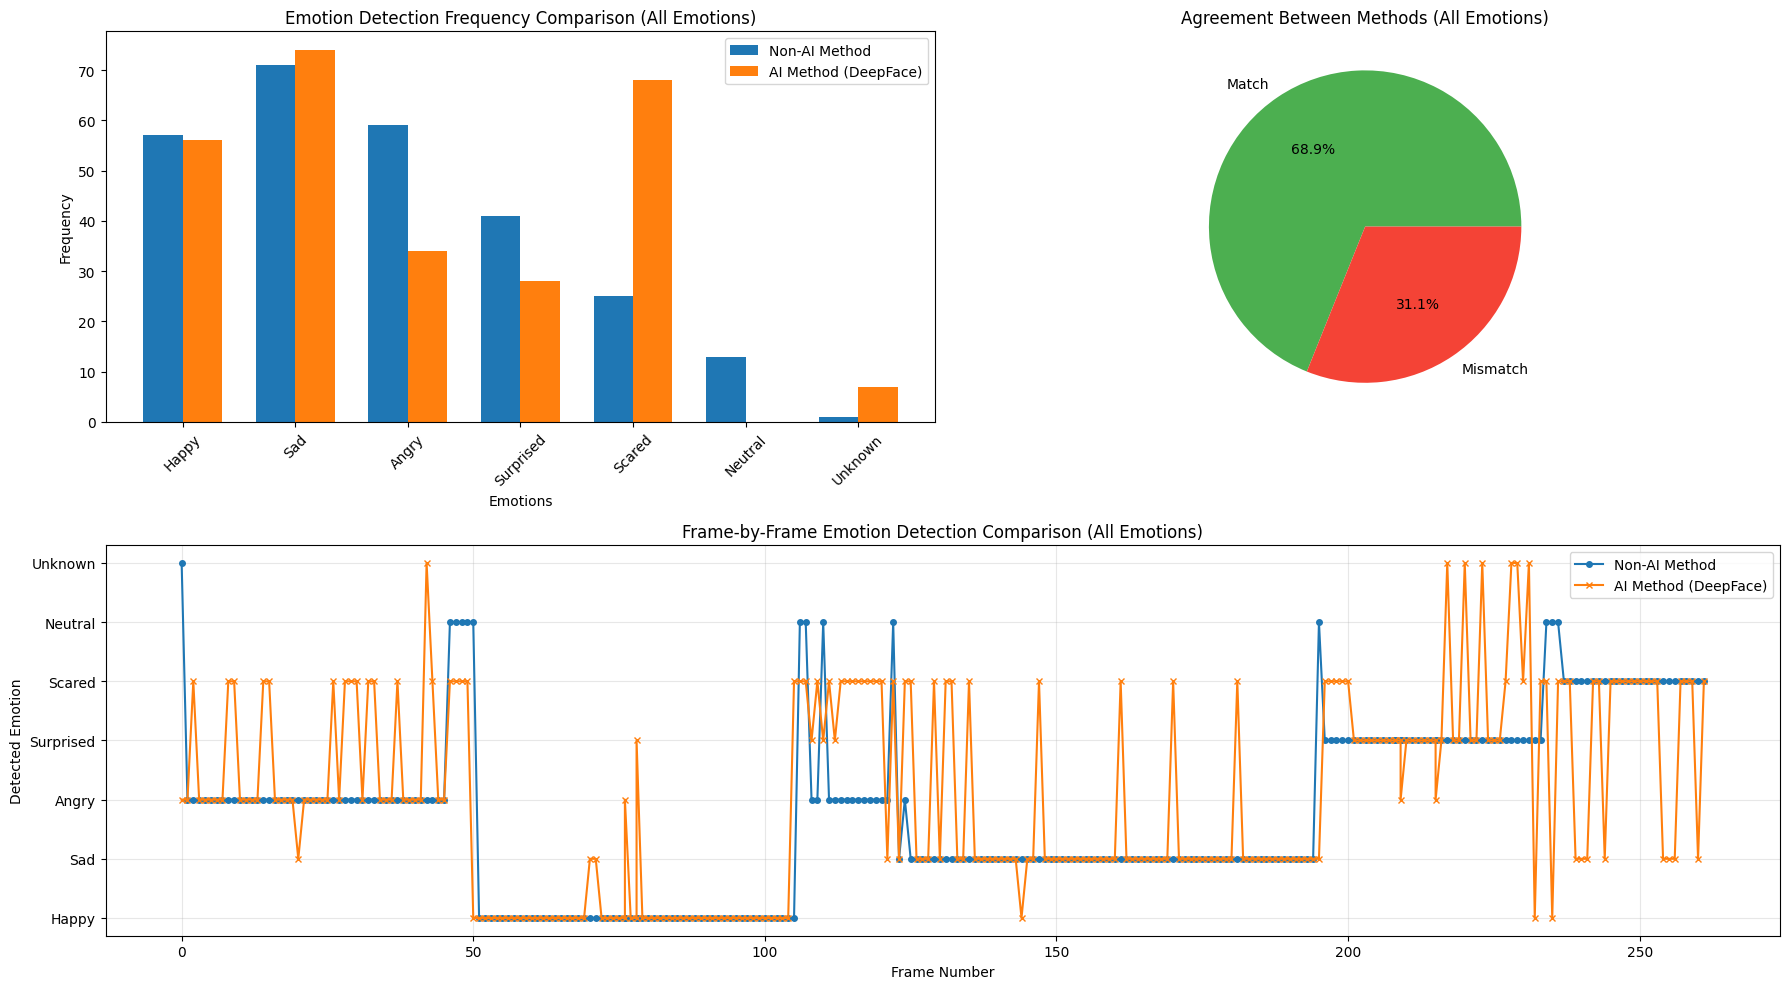

In [ ]:
#analyze_emotions(video_path="data/all3.avi")

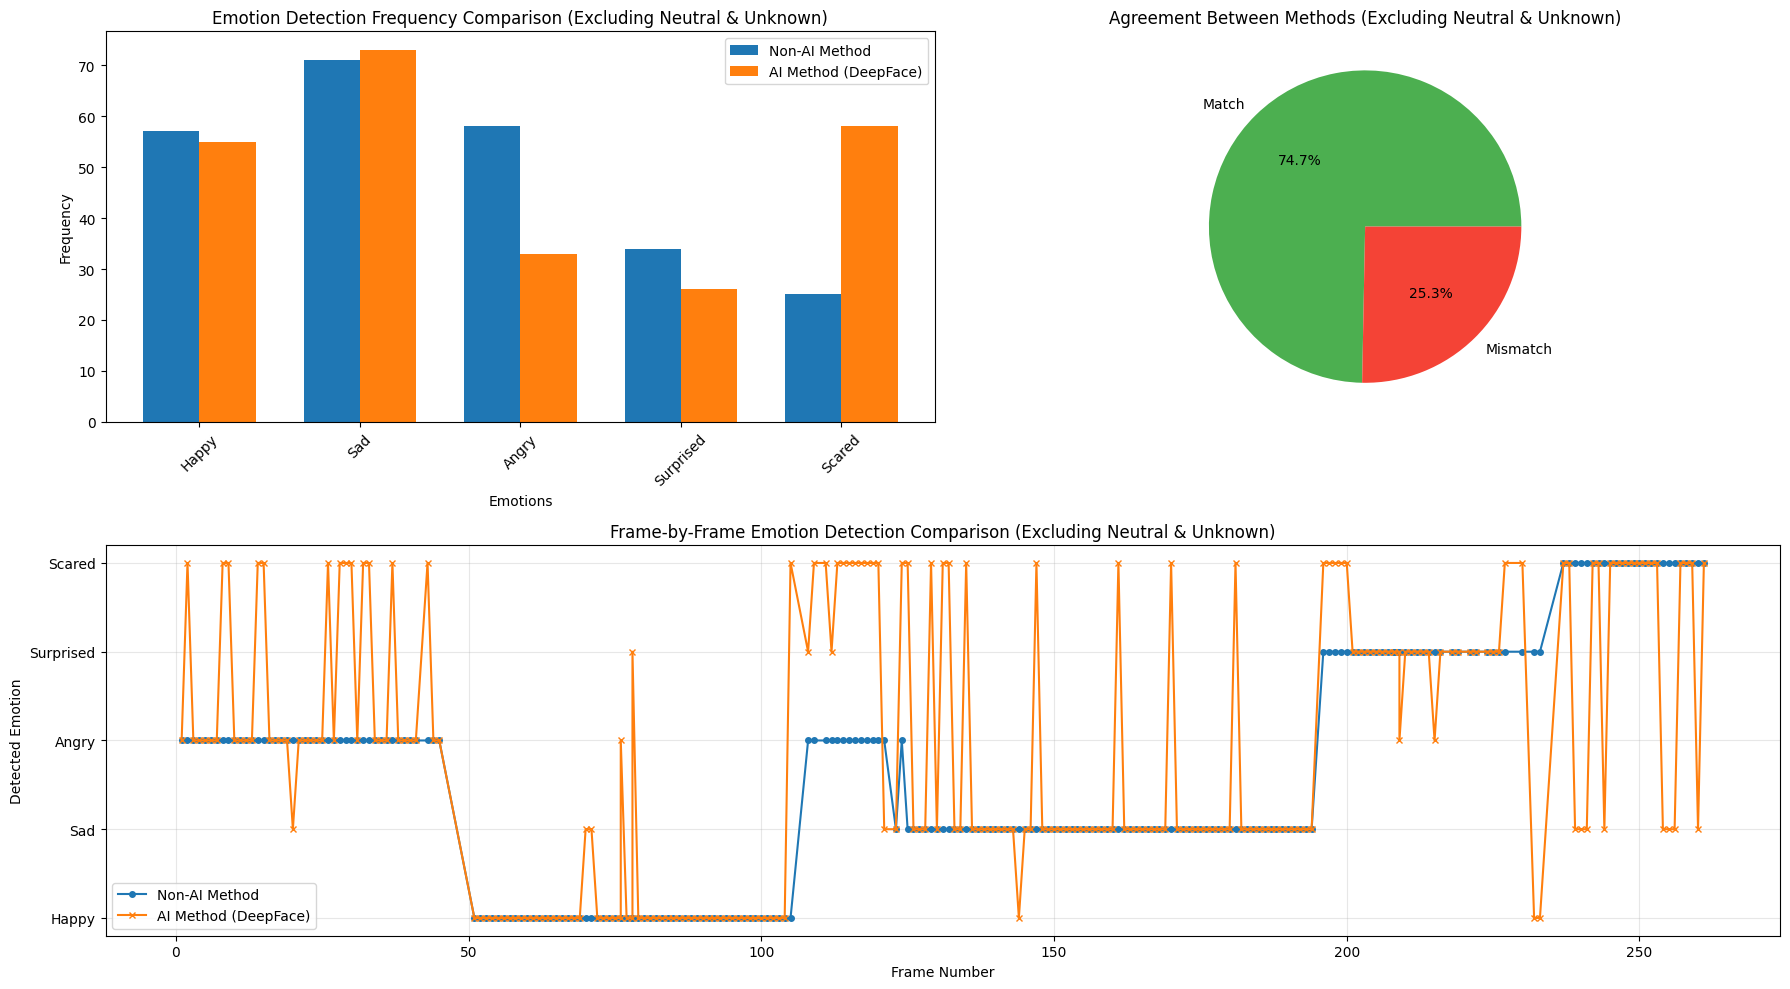

In [ ]:
#analyze_emotions(video_path="data/all3.avi", exclude_neutral_unknown=True)

# Conclusion

In this project, the **non-AI approach** for recognizing facial emotions using key facial landmarks has shown promising results. This system works well in scenarios where the person is actively imitating emotions, as it can reliably classify emotions based on the precise movements and relative positions of the facial landmarks. In controlled settings where the person is consciously exaggerating or mimicking emotions, the non-AI system outperforms the AI model, as the facial expressions are more easily detectable by the fixed thresholds we have defined.

However, while the non-AI system works well in these specific scenarios, it is important to note that it is **less flexible** than an AI-based model. The non-AI system struggles with **real-world variability**, such as subtle or natural emotional expressions or varied facial features.